In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc3 as pm
import arviz as az
# Import the other core data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable C:\Program
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [3]:
# True parameter values
alpha_, sigma_ = 1, 1
beta_ = [1, 2.5]

# Size of dataset
size = 10

data = pd.DataFrame()
# Predictor variable
data['x1'] = np.linspace(0,1,size)
data['x2'] = np.linspace(0,0.2,size)

# Simulate outcome variable
data['y'] = alpha_ + beta_[0] * data['x1'] + beta_[1] * data['x2']
data['y_measure'] = data['y'] + rng.normal(size=size) * sigma_

<Axes: xlabel='x2'>

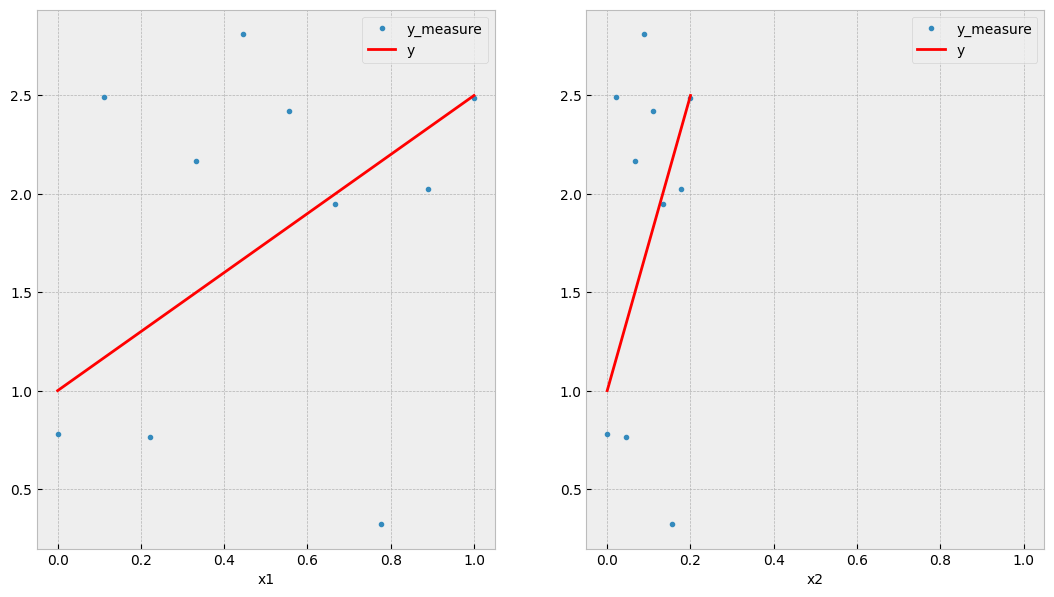

In [4]:
fig,axes=plt.subplots(ncols=2, sharex=True)
data.plot(x='x1', y='y_measure', style='.', ax=axes[0])
data.plot(x='x1', y='y', style='r-', ax=axes[0])
data.plot(x='x2', y='y_measure', style='.', ax=axes[1])
data.plot(x='x2', y='y', style='r-', ax=axes[1])

## OLS regression

In [5]:
# OLS line
formula = 'y_measure ~ x1 + x2'
results = smf.ols(formula, data=data).fit()

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_measure   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.086
Method:                 Least Squares   F-statistic:                    0.2881
Date:                Fri, 03 Mar 2023   Prob (F-statistic):              0.606
Time:                        12:40:36   Log-Likelihood:                -12.139
No. Observations:                  10   AIC:                             28.28
Df Residuals:                       8   BIC:                             28.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5796      0.535      2.951      0.018       0.345       2.814
x1             0.4657      0.868      0.537      0.606      -1.535       2.467
x2             0.0931      0.174      0.537      0.606      -0.307       0.493
==============================================================================
Omnibus:                        1.413   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.493   Jarque-Bera (JB):                0.970
Skew:                          -0.675   Prob(JB):                        0.616
Kurtosis:                       2.288   Cond. No.                     7.16e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.51e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<Axes: xlabel='x2'>

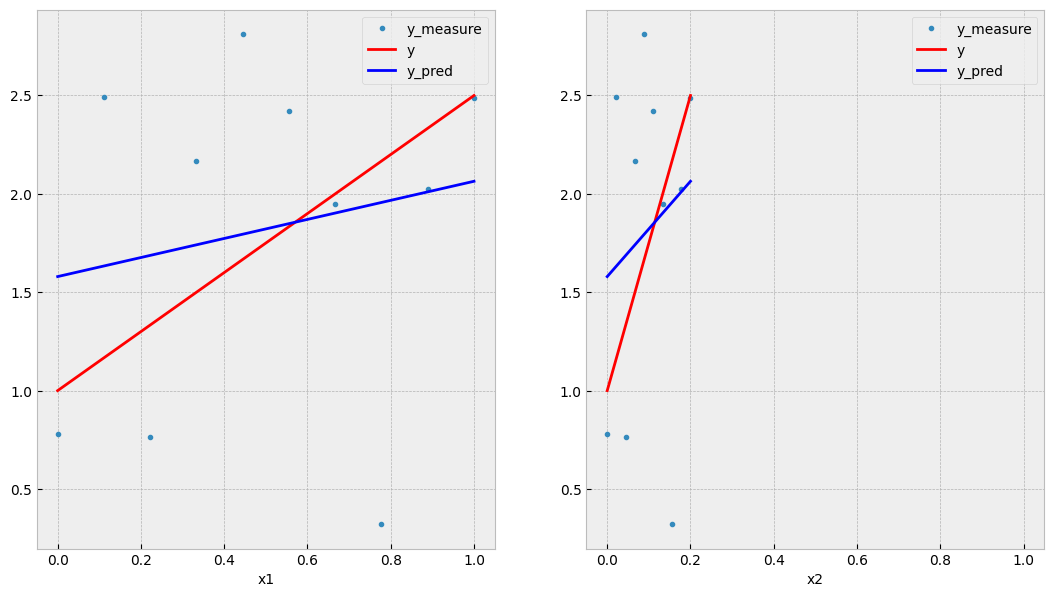

In [44]:
X = data[['x1','x2']]
prediction = X.copy()
prediction['y_pred'] = results.predict(X)

fig,axes=plt.subplots(ncols=2, sharex=True)
data.plot(x='x1', y='y_measure', style='.', ax=axes[0])
data.plot(x='x1', y='y', style='r-', ax=axes[0])
prediction.plot(x='x1', y='y_pred', style='b-', ax=axes[0])

data.plot(x='x2', y='y_measure', style='.', ax=axes[1])
data.plot(x='x2', y='y', style='r-', ax=axes[1])
prediction.plot(x='x2', y='y_pred', style='b-', ax=axes[1])

## Bayesian

In [45]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=alpha_, sigma=1)
    beta = pm.Normal("beta", mu=beta_, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * data['x1'] + beta[1] * data['x2']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data['y_measure'])

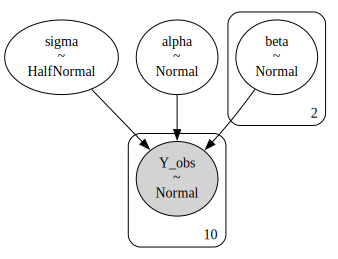

In [46]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

pm.model_to_graphviz(basic_model)

In [47]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8824901880104672, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


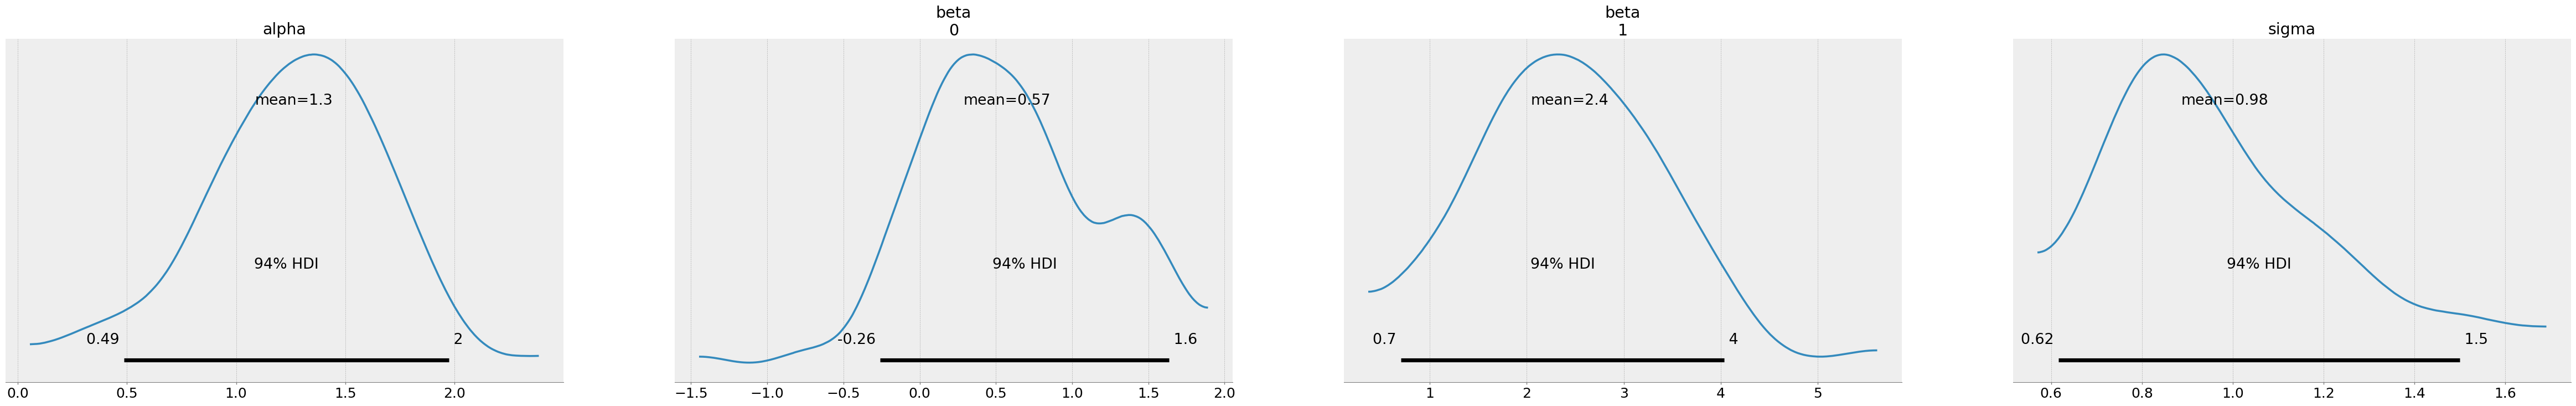

In [48]:
with basic_model:
    az.plot_posterior(idata,
                      var_names=['alpha', 'beta', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')

In [49]:
az.summary(idata)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.266,0.400,0.487,1.975,0.042,0.029,98.0,73.0,1.06
beta[0],0.574,0.576,-0.258,1.635,0.052,0.047,131.0,130.0,1.01
beta[1],2.445,0.945,0.703,4.036,0.086,0.064,126.0,131.0,1.00
sigma,0.982,0.247,0.616,1.500,0.022,0.016,150.0,104.0,1.04


In [50]:
with basic_model:   
    y_test = pm.sample_posterior_predictive(idata)

In [56]:
prediction['bayes'] = idata['alpha'].mean() + idata['beta'][0].mean() * data['x1'] + idata['beta'][1].mean() * data['x2']

<Axes: xlabel='x2'>

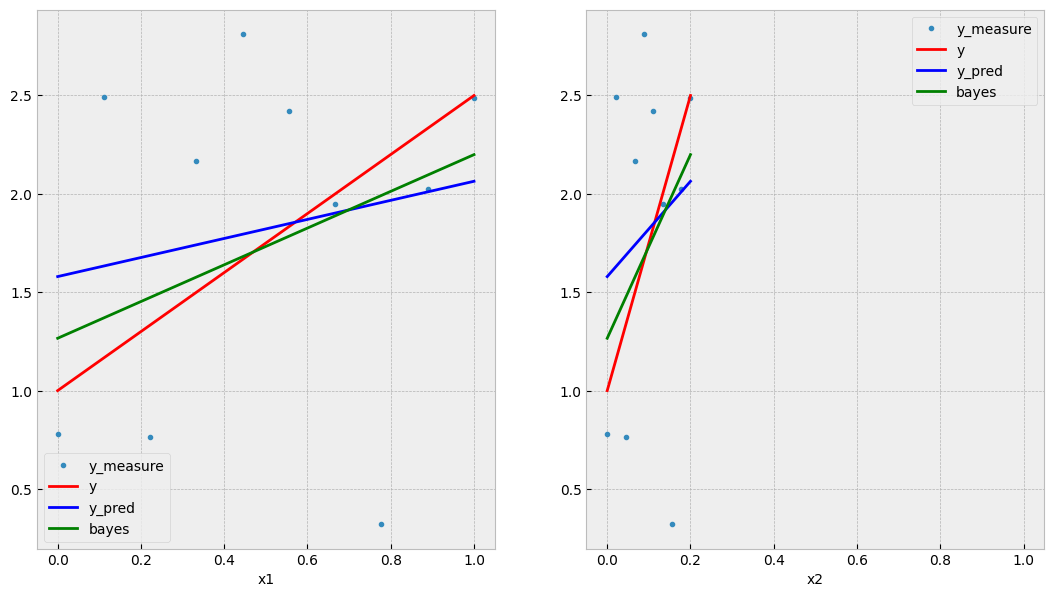

In [57]:
fig,axes=plt.subplots(ncols=2, sharex=True)
data.plot(x='x1', y='y_measure', style='.', ax=axes[0])
data.plot(x='x1', y='y', style='r-', ax=axes[0])
prediction.plot(x='x1', y='y_pred', style='b-', ax=axes[0])
prediction.plot(x='x1', y='bayes', style='g-', ax=axes[0])

data.plot(x='x2', y='y_measure', style='.', ax=axes[1])
data.plot(x='x2', y='y', style='r-', ax=axes[1])
prediction.plot(x='x2', y='y_pred', style='b-', ax=axes[1])
prediction.plot(x='x2', y='bayes', style='g-', ax=axes[1])

<Axes: xlabel='x1'>

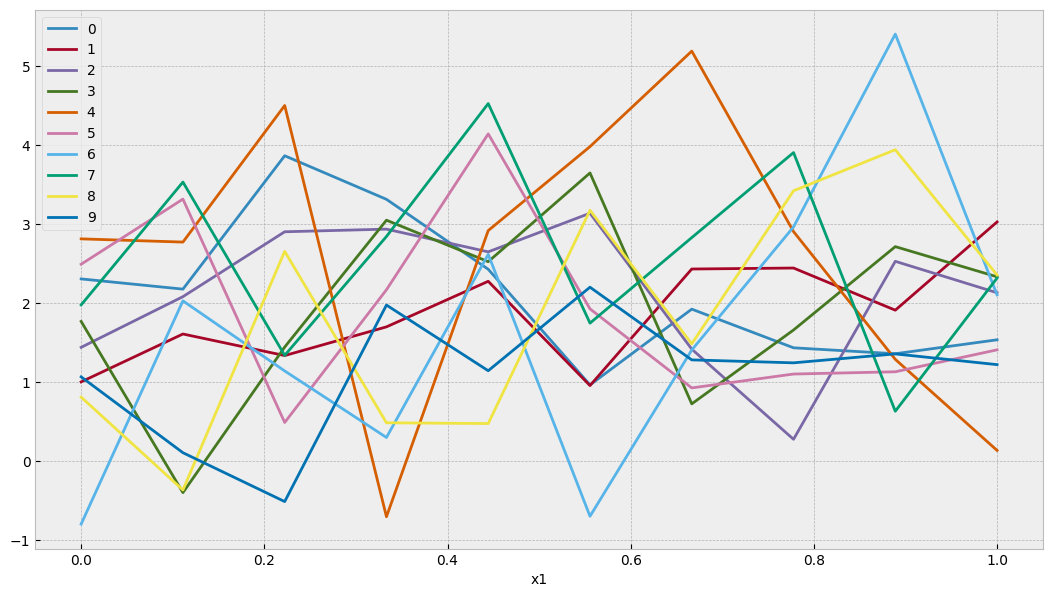

In [69]:
df_trace = pd.DataFrame(y_test['Y_obs'].T)
df_trace['x1'] = data['x1']
df_trace['x2'] = data['x2']

fig,ax=plt.subplots()
df_trace.plot(x='x1', y=[i for i in range(size)], ax=ax)